# Problem Statement -predicting Zeta Disease infection

## INTRODUCTION

Mars Mission Control needs a good data-driven system for predicting Zeta Disease infection on the International Mars Colony.
Use the `_zeta-disease_training-data_` dataset to build a model that can predict who will be infected by Zeta Disease.
Apply your model to the `_zeta-disease_prediction-data_` dataset to predict who will be infected by Zeta Disease.

## DATASET

The dataset includes 9 columns with information on 800 people.
1.	age : in years
2.	weight : body weight in pounds (lbs)
3.	bmi : Body Mass Index (weight in kg/(height in m)2)
4.	blood_pressure : resting blood pressure (mm Hg)
5.	insulin_test : inuslin test value
6.	liver_stress_test : liver_stress_test value
7.	cardio_stress_test : cardio_stress_test value
8.	years_smoking : number of years of smoking
9.	zeta_disease :
   1 = yes          0 = no


## Data/Libraries import 

In [87]:
#Data import etc..
import pandas as pd
import numpy as np

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#model Building
from sklearn.model_selection import train_test_split



#Metrics for model performance analysis 
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,roc_auc_score
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedKFold

#importing classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

#importing libraries for data handling 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [88]:
df =pd.read_csv('zeta_train.csv') #Importing data
df_test = pd.read_csv('zeta_test.csv') 

In [89]:
print(f'shape of training data : {df.shape}\nshape of testing data :  {df_test.shape}')

shape of training data : (800, 9)
shape of testing data :  (20, 9)


In [90]:
df.head() #checking if import worked as expected

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [91]:
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


### EDA and Data cleaning

In [92]:
df.isna().sum() # checking for null values

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
zeta_disease          0
dtype: int64

In [93]:
df.info() # checking data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


There are no null/Na values.The data seems to be clean in the preliminary analysis.

In [94]:
def plot_box_plot(df, attributes, figSize=(45,10)):
  plt.figure(figsize=figSize)
  sns.set_style("darkgrid")
  sns.set_context("notebook", font_scale=1.4)
  for n,attribute in enumerate(attributes):
    plt.subplot(1,8,n+1) # subplot of 8 attributes 
    sns.boxplot(data=df, y=attribute, x= 'zeta_disease', hue='zeta_disease',
                showfliers=False, palette=("plasma")) # seaborn to plot a box plot , hue and x axis indicates disease +/-
  plt.show()

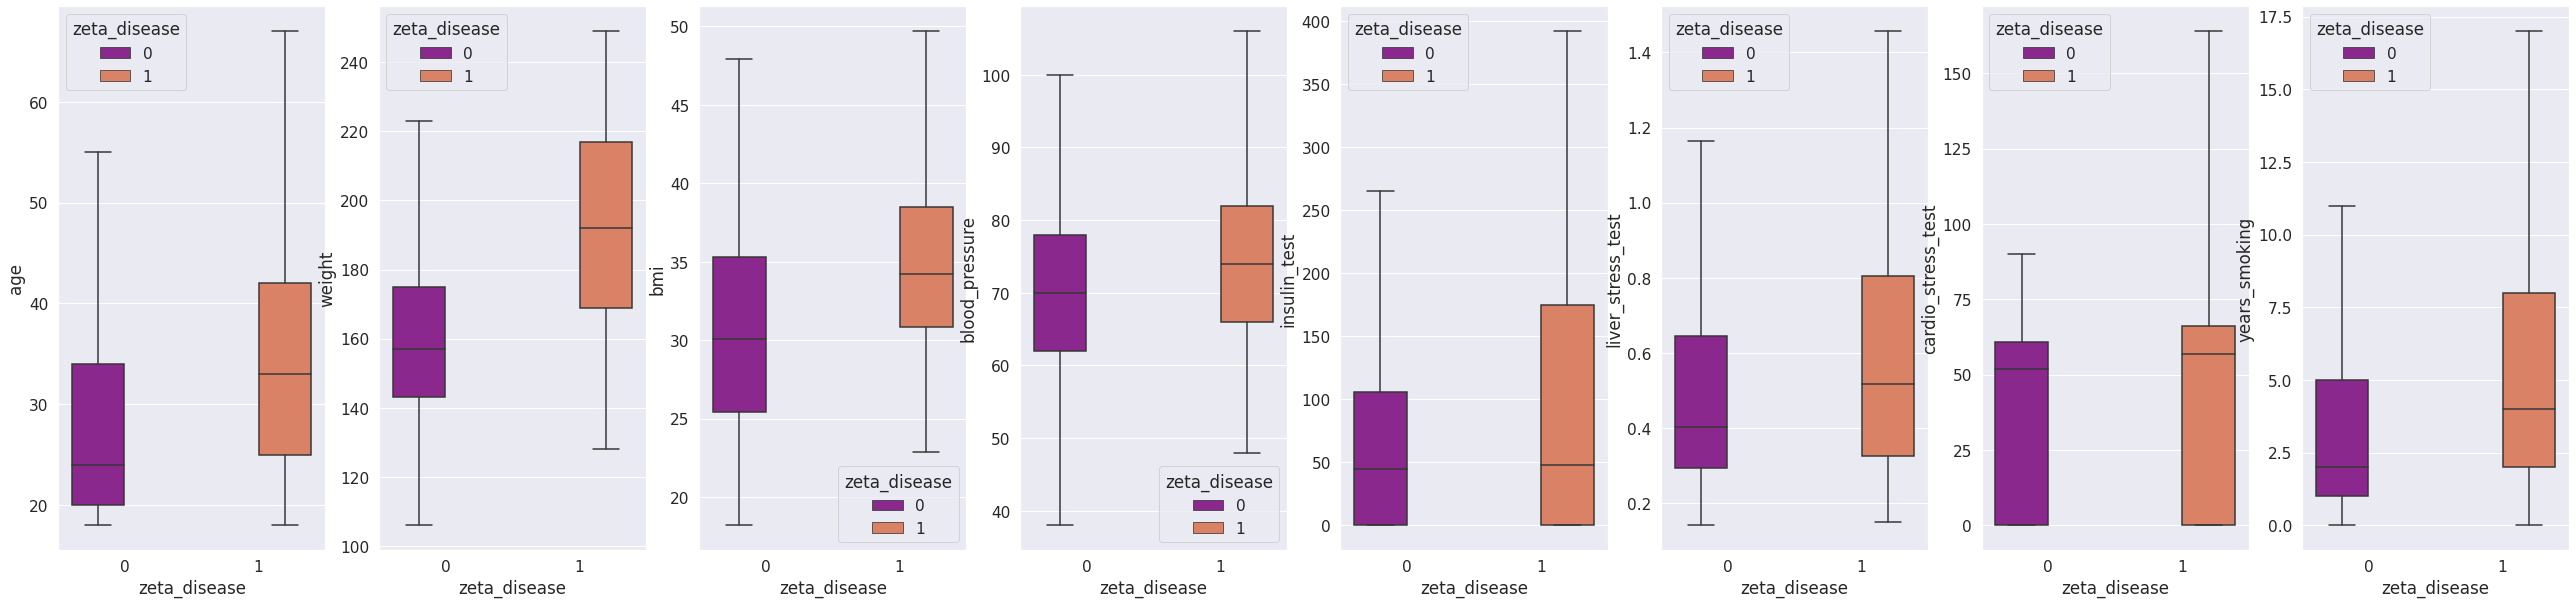

In [95]:
plot_box_plot(df , df.columns[:8])

People with zeta disease seem to have higher BP , insulin levels , BMI , stressed liver, are aged and are over weight.

Even though outliers are present in the data , it may not be a good idea to remove them as they may play a role in classifying.Moreoverm we have very small set of data . I will consider having a word with the business or SME before eliminating the outliers. For now , I will proceed without removing the outliers. 

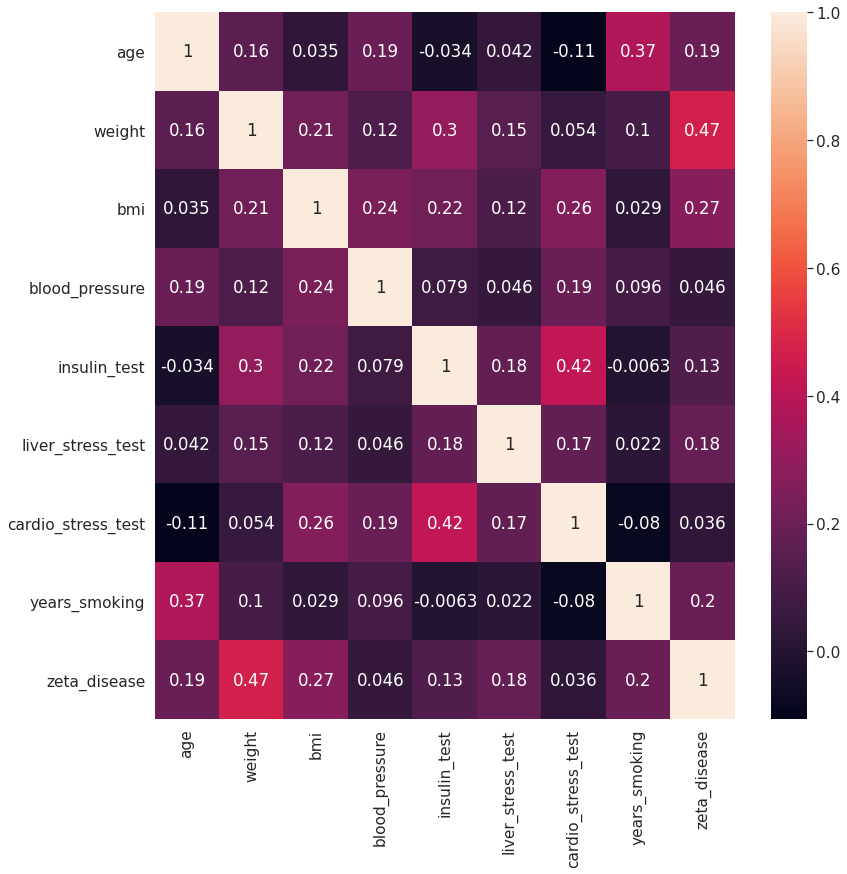

In [96]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr() , annot= True)
plt.show()

Cadio stress test and  insulin seems to be somewhat correlated (0.42).The rest arent as correlated.

## Model Building

### Metrics to analyse model performance

In [97]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right" )  
    plt.xlabel("Threshold" )        
    plt.grid(True)                             
    #plt.axis([-1 ,1, 0, 1])   

In [98]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

In [99]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                     
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 

In [100]:
def metric(y_train,y_train_pred,classifier):
    print(f'cofusion matrix  for {classifier} Classifier:\n {confusion_matrix(y_train, y_train_pred)}')
    print(f'FOR {classifier} Classifier\nROC SCORE IS : {roc_auc_score(y_train,y_train_pred)}\naccuracy is {metrics.accuracy_score(y_train ,y_train_pred )}\
    \nprecision score is :{precision_score(y_train, y_train_pred)}\
    \nrecall is {recall_score(y_train, y_train_pred) }\nf1 score is : {f1_score(y_train, y_train_pred)}')
    print(f'Classification Report -> \n{metrics.classification_report(y_train, y_train_pred)}')
    print(f'Sensitivity is {sensitivity_specificity_support(y_train, y_train_pred, average="binary")[0]}\nSpecificity is {sensitivity_specificity_support(y_train, y_train_pred, average="binary")[1]}' )

### Train Test split

In [101]:
#spliting into data into train & test for validating our models 
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,:-1],  df.iloc[:,-1], test_size=0.2, random_state=42)
print(f'shape of training features and Labels: {X_train.shape , y_train.shape}\nshape of testing features and Labels :  {X_test.shape , y_test.shape}') 

shape of training features and Labels: ((640, 8), (640,))
shape of testing features and Labels :  ((160, 8), (160,))


### Model 1

As we have limited data to work with , Ensemble methods , k neighbours classifier or SVC can fit the bill. I will begin with Bootstrap aggregation/ Random forest and move to others if it doesn't work.We can also augment the data if need be .But I'd like to hold that thought until a discussion with SME/business.

In [102]:
#scaling data
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [103]:
## Building a pipleine
forest_clf = RandomForestClassifier(random_state= 42)
steps =[
        ('forest_clf',forest_clf)
]

RF_clf = Pipeline(steps)

n_estimators = [25, 100,150]
max_depth = [5, 8, 15]
min_samples_split = [2,10,30]
min_samples_leaf = [  5, 10] 

params = dict(forest_clf__n_estimators = n_estimators, forest_clf__max_depth = max_depth,  
              forest_clf__min_samples_split = min_samples_split, 
             forest_clf__min_samples_leaf = min_samples_leaf)

folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 4)

model = GridSearchCV(estimator=RF_clf, cv=folds, param_grid=params, scoring='roc_auc')

In [104]:
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('forest_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                          

In [105]:
model_f = model.best_estimator_

In [106]:
y_train_pred = model_f.predict(X_train_scaled)

metric(y_train,y_train_pred,'RF_CLF_train')

cofusion matrix  for RF_CLF_train Classifier:
 [[382  30]
 [ 61 167]]
FOR RF_CLF_train Classifier
ROC SCORE IS : 0.8298203031851474
accuracy is 0.8578125    
precision score is :0.8477157360406091    
recall is 0.7324561403508771
f1 score is : 0.7858823529411765
Classification Report -> 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       412
           1       0.85      0.73      0.79       228

    accuracy                           0.86       640
   macro avg       0.86      0.83      0.84       640
weighted avg       0.86      0.86      0.86       640

Sensitivity is 0.7324561403508771
Specificity is 0.9271844660194175


In [107]:
y_pred = model_f.predict(X_test_scaled)

metric(y_test,y_pred,'RF_CLF')

cofusion matrix  for RF_CLF Classifier:
 [[94 15]
 [23 28]]
FOR RF_CLF Classifier
ROC SCORE IS : 0.7057024644720273
accuracy is 0.7625    
precision score is :0.6511627906976745    
recall is 0.5490196078431373
f1 score is : 0.5957446808510639
Classification Report -> 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       109
           1       0.65      0.55      0.60        51

    accuracy                           0.76       160
   macro avg       0.73      0.71      0.71       160
weighted avg       0.75      0.76      0.76       160

Sensitivity is 0.5490196078431373
Specificity is 0.8623853211009175


We are getting good accuracy and specificity with this model . There is good precision recall balance. Hyper parameter tuning will help ,** but due to limited computational capabilities , I cant do it .But i'll try changing the threshold and check if that helps.  ** 

### Trying different thresholds

In [108]:
y_probas = cross_val_predict(model_f , X_train_scaled.astype('float64'),y_train,cv=3
                                   ,method = 'predict_proba')
y_probas_clf = y_probas[:,1]


fpr_ , tpr_ , threshold_ = roc_curve(y_train,y_probas_clf)
roc_auc_score(y_train,y_probas_clf)

0.8348556463975473

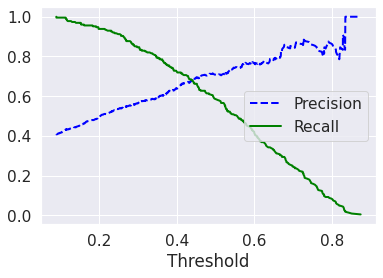

In [109]:
precisions, recalls, thresholds = precision_recall_curve(y_train,y_probas_clf)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [110]:
thresh = 0.42

In [111]:
train_final =pd.DataFrame({'actual':y_train, 'predicted_prob':y_probas_clf})
train_final['predicted']=train_final.predicted_prob.apply(lambda x: 1 if x>thresh else 0)
metric(train_final['actual'],train_final['predicted'],'RF Train CLASSIFIER')

cofusion matrix  for RF Train CLASSIFIER Classifier:
 [[332  80]
 [ 67 161]]
FOR RF Train CLASSIFIER Classifier
ROC SCORE IS : 0.7559827967978198
accuracy is 0.7703125    
precision score is :0.6680497925311203    
recall is 0.706140350877193
f1 score is : 0.6865671641791045
Classification Report -> 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       412
           1       0.67      0.71      0.69       228

    accuracy                           0.77       640
   macro avg       0.75      0.76      0.75       640
weighted avg       0.77      0.77      0.77       640

Sensitivity is 0.706140350877193
Specificity is 0.8058252427184466


In [112]:
y_test_probas = model_f.predict_proba(X_test_scaled)


In [113]:
y_test_probas_clf = y_test_probas[:,1]


fpr_ , tpr_ , threshold_ = roc_curve(y_test,y_test_probas_clf)
roc_auc_score(y_test,y_test_probas_clf)

0.8283864004317324

In [114]:
train_final =pd.DataFrame({'actual':y_test, 'predicted_prob':y_test_probas_clf})
train_final['predicted']=train_final.predicted_prob.apply(lambda x: 1 if x>thresh else 0)
metric(train_final['actual'],train_final['predicted'],'RF Train CLASSIFIER')

cofusion matrix  for RF Train CLASSIFIER Classifier:
 [[87 22]
 [16 35]]
FOR RF Train CLASSIFIER Classifier
ROC SCORE IS : 0.7422198237093002
accuracy is 0.7625    
precision score is :0.6140350877192983    
recall is 0.6862745098039216
f1 score is : 0.6481481481481481
Classification Report -> 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       109
           1       0.61      0.69      0.65        51

    accuracy                           0.76       160
   macro avg       0.73      0.74      0.73       160
weighted avg       0.77      0.76      0.77       160

Sensitivity is 0.6862745098039216
Specificity is 0.7981651376146789


Changing threshold has broght a good specificity and sensitvity balance . The precision recall rate has also improved .

## Testing

In [115]:
df_test.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [116]:
df_test_scaled = std_scaler.transform(df_test.iloc[:,:-1])
df_test_probas = model_f.predict_proba(df_test_scaled)
df_test_probas = np.where(df_test_probas[:,1]<thresh,0,1)
zeta_disease_predict = pd.DataFrame(df_test_probas)
df_predicted = pd.concat([df_test, zeta_disease_predict], axis=1)
df_predicted.drop('zeta_disease',inplace=True,axis =1)
df_predicted.rename(columns={0: "zeta_disease"},inplace=True)

In [117]:
df_predicted

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,0
1,27,179,35.5,89,156,1.6608,43,6,1
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,1
4,60,193,29.8,62,192,1.7798,65,9,1
5,45,120,36.5,108,50,1.2978,54,12,1
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,0
8,36,195,30.5,59,141,1.4498,59,6,1
9,19,193,25.8,84,66,1.7938,50,3,0


In [118]:
df_predicted.to_csv('prediction.csv')